In [1]:
import os
n_jobs = 12
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import exceptions
# from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load
from QiskitRegressor import QiskitRegressor

In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1,AL=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        for j in range(AL):        
            HardwareEfficient(qc,nqubits,paramname=f'theta{i}_{j}')
            qc.barrier()
    return qc

In [4]:

top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)[0:4]
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:4]
y_ddcc_train = y_ddcc_train.reshape(-1,64)[0:4]
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:4]


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test

# X_train = [X_train[i:i+4] for i in range(0,len(X_train),4)]
# X_test = [X_test[i:i+4] for i in range(0,len(X_test),4)]
scaler = ddcc_scaler

# print(len(X_train),X_train[0].shape,X_train[-1].shape)
print(y_train.shape, y_test.shape)

(4, 64) (4, 64)


/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
num_qubits = 5
RUD = 1
AL = 5

In [6]:
optimization_level = 2
shots = 3072
# shots = 1024.0 * 1
resilience_level = 1

In [7]:
optimization_level = int(optimization_level)
shots = int(shots)
# shots = 1024.0 * 1
resilience_level = int(resilience_level)

In [8]:
# 
qc = circuit(num_qubits,RUD,AL)

observables_labels = ''.join(['I']*(num_qubits-1))+"Z"

In [9]:
model = QiskitRegressor(qc,
                        num_qubits,
                        AL,
                        RUD,
                        'real', #'fake',
                        observables_labels,
                        verbose=True,
                        instance='pinq-quebec-hub/univ-toronto/default',
                        iterations=90,
                        n_jobs=n_jobs,
                        parameterpath='./final_state_model.bin')
model.fit(X_train,y_train)



./final_state_model.bin
Parameters loaded
[-3.12796163  3.20923479 -1.15356047  0.79727259  1.45787692 -2.84003282
  3.10217594  2.21913693  2.17861986 -0.90578323  0.60926206  1.08842887
  1.30878757 -1.83754319  1.05930109  2.92869346 -0.45472001 -0.53390713
 -1.94943806  0.96644527  1.83382822  2.59903043 -1.27248814 -0.24476434
 -2.55148033 -2.19211736  3.18233718  2.48878626 -0.54848978 -2.79958123
  1.58113557 -0.03487004 -2.40488905  2.23078263  1.30281402 -0.52182491
  0.98516107 -1.73367864 -0.3479275   2.34534114 -0.16352274  0.48817249
  2.62697457  0.99203839  2.93104541  2.76133689  2.87866402 -2.78879742
  0.17609349 -0.35129591  1.53780447  2.8570011  -0.27269594 -2.34909155
  2.65752438 -3.00081876  0.74611123 -0.85515604 -1.61543159  2.91095663
 -1.70506496 -1.62327844 -2.60549583  2.14665867 -2.26107756  2.14784551
  2.05804096  1.67840528  2.48059465  2.74975017  1.74108432  1.59959627
 -1.80899923 -2.10894248  1.38774611]


[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])]
<IBMBackend('ibm_quebec')>


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5414 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 139.9424 s
Iters. done: 1 Current cost: 0.14320107790044384 Accuracy: -0.5830524906284413 Time: 159.5581598766148


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.0768 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 144.1979 s
Iters. done: 2 Current cost: 0.13951081354220435 Accuracy: -0.5422575310580269 Time: 161.38285987079144


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5426 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 138.8112 s
Iters. done: 3 Current cost: 0.13932144128770763 Accuracy: -0.5401640676321064 Time: 159.43948113173246


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4575 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 139.5602 s
Iters. done: 4 Current cost: 0.14869836861372232 Accuracy: -0.6438236795255965 Time: 160.11058083549142


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.3613 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 139.6993 s
Iters. done: 5 Current cost: 0.14929029495737023 Accuracy: -0.6503672788219081 Time: 161.1328065060079


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5873 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 141.9858 s
Iters. done: 6 Current cost: 0.1321530079405098 Accuracy: -0.4609188103298194 Time: 162.6596758402884


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8515 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.9931 s
Iters. done: 7 Current cost: 0.13487314042490045 Accuracy: -0.4909892020292985 Time: 160.9286067634821


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.9846 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 141.9673 s
Iters. done: 8 Current cost: 0.1363373166325439 Accuracy: -0.507175307791996 Time: 162.02601638063788


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6382 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 143.3773 s
Iters. done: 9 Current cost: 0.1357973731868674 Accuracy: -0.5012063665730555 Time: 163.09742568433285


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.2025 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 148.1513 s
Iters. done: 10 Current cost: 0.13326179599637156 Accuracy: -0.4731761879916785 Time: 167.43213103711605


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7923 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 143.8562 s
Iters. done: 11 Current cost: 0.1321446170963491 Accuracy: -0.460826051623378 Time: 164.72471093013883


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4538 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 146.8545 s
Iters. done: 12 Current cost: 0.13954658939463377 Accuracy: -0.5426530242562841 Time: 166.38716255500913


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6124 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 316.8181 s
Iters. done: 13 Current cost: 0.12655753042130324 Accuracy: -0.3990621905829095 Time: 335.508856728673


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6066 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 141.1358 s
Iters. done: 14 Current cost: 0.1273593421239917 Accuracy: -0.40792602060127314 Time: 160.82586977258325


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.8775 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 142.8270 s
Iters. done: 15 Current cost: 0.12458509059536402 Accuracy: -0.37725735625590384 Time: 163.79320404678583


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7204 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 147.1002 s
Iters. done: 16 Current cost: 0.1241043461571899 Accuracy: -0.37194284542005396 Time: 165.90377413108945


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4567 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 145.4348 s
Iters. done: 17 Current cost: 0.1186783609321306 Accuracy: -0.31195992105537185 Time: 165.9757499396801


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7266 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 146.3719 s
Iters. done: 18 Current cost: 0.12092908431234627 Accuracy: -0.3368411112321885 Time: 166.18070076406002


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.6786 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 149.5506 s
Iters. done: 19 Current cost: 0.11959237348079131 Accuracy: -0.3220641036693388 Time: 167.31267708167434


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.0314 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 244.6014 s
Iters. done: 20 Current cost: 0.11775999077555045 Accuracy: -0.30180756616385507 Time: 262.7184811979532


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.7961 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 219.2659 s
Iters. done: 21 Current cost: 0.12346478521852933 Accuracy: -0.3648726574598824 Time: 242.4370078779757


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4210 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 150.6930 s
Iters. done: 22 Current cost: 0.11732183350326447 Accuracy: -0.2969638459115431 Time: 170.19027544930577


Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.4151 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 145.7233 s
Iters. done: 23 Current cost: 0.11527897827643818 Accuracy: -0.2743805867473281 Time: 170.22667970508337


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.3928 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 151.6342 s
Iters. done: 24 Current cost: 0.1207249182249821 Accuracy: -0.33458410564366625 Time: 169.11102055758238


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1136 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 149.6488 s
Iters. done: 25 Current cost: 0.12021248432468684 Accuracy: -0.328919275643512 Time: 169.84955736249685


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1229 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 149.4613 s
Iters. done: 26 Current cost: 0.13121784597155567 Accuracy: -0.45058082610652317 Time: 170.66706164181232


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.4146 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 147.6410 s
Iters. done: 27 Current cost: 0.1234578902332133 Accuracy: -0.36479643510291826 Time: 171.14196786284447


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1713 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.0239 s
Iters. done: 28 Current cost: 0.1170244438409305 Accuracy: -0.2936762767636891 Time: 158.27957946062088


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.0359 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 147.9046 s
Iters. done: 29 Current cost: 0.1250742294846069 Accuracy: -0.38266466567167146 Time: 169.0204789340496


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1321 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 148.3089 s
Iters. done: 30 Current cost: 0.11435395398457188 Accuracy: -0.264154672036345 Time: 168.52548456564546


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.2574 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 149.9279 s
Iters. done: 31 Current cost: 0.11655067035665383 Accuracy: -0.2884388280986776 Time: 169.26999762281775


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.2617 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 148.7583 s
Iters. done: 32 Current cost: 0.11539897843204142 Accuracy: -0.27570715878148255 Time: 169.1065895035863


Mappings: 0it [00:00, ?it/s]

Submitted to device in 24.7689 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 166.4685 s
Iters. done: 33 Current cost: 0.1118774518522378 Accuracy: -0.2367775536087613 Time: 191.32222184166312


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6932 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 151.4032 s
Iters. done: 34 Current cost: 0.11561612030934228 Accuracy: -0.2781076085177605 Time: 172.1818866468966


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.9839 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 1428.2978 s
Iters. done: 35 Current cost: 0.1207918786123788 Accuracy: -0.33532433616145263 Time: 1452.3658096455038


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4109 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.4691 s
Iters. done: 36 Current cost: 0.12888995624570942 Accuracy: -0.42484658106842876 Time: 140.96640703082085


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4215 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.7392 s
Iters. done: 37 Current cost: 0.11990433292587699 Accuracy: -0.32551273816119153 Time: 140.2451227195561


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.5364 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.2076 s
Iters. done: 38 Current cost: 0.12258168304772452 Accuracy: -0.35511018142639994 Time: 143.3224254436791


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.0194 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 124.2301 s
Iters. done: 39 Current cost: 0.12106468552881997 Accuracy: -0.33834014913482346 Time: 144.3360578045249


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.3204 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.6896 s
Iters. done: 40 Current cost: 0.11145532550470008 Accuracy: -0.23211105126375764 Time: 140.0939389578998


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2422 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.2791 s
Iters. done: 41 Current cost: 0.11355914339278342 Accuracy: -0.25536823756702276 Time: 138.6078310497105


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1637 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.7391 s
Iters. done: 42 Current cost: 0.11735637608609972 Accuracy: -0.29734570561952745 Time: 137.98530154675245


Mappings: 0it [00:00, ?it/s]

Submitted to device in 23.6311 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 115.3839 s
Iters. done: 43 Current cost: 0.11989668518433107 Accuracy: -0.3254281942703252 Time: 139.09607249498367


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5701 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.2873 s
Iters. done: 44 Current cost: 0.12393919497073226 Accuracy: -0.37011713990941675 Time: 140.94138304144144


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6883 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.2017 s
Iters. done: 45 Current cost: 0.11780756816210526 Accuracy: -0.3023335224023658 Time: 140.96883572638035


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7948 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.5179 s
Iters. done: 46 Current cost: 0.11646128919129536 Accuracy: -0.28745074142705085 Time: 140.394687846303


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6788 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.2123 s
Iters. done: 47 Current cost: 0.11418065162347987 Accuracy: -0.2622388573065899 Time: 140.97518686950207


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2858 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.4758 s
Iters. done: 48 Current cost: 0.11287498005394007 Accuracy: -0.24780498110672156 Time: 140.8459316790104


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6375 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.7009 s
Iters. done: 49 Current cost: 0.1179840852030361 Accuracy: -0.3042848746224811 Time: 138.42335707321763


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4349 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.1300 s
Iters. done: 50 Current cost: 0.12315792875089789 Accuracy: -0.3614804351213947 Time: 138.64638493210077


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2638 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.2298 s
Iters. done: 51 Current cost: 0.11400987187289494 Accuracy: -0.2603509294119386 Time: 138.58001597225666


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6691 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.7439 s
Iters. done: 52 Current cost: 0.11992072094015774 Accuracy: -0.3256939036049433 Time: 139.49837846681476


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3563 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.2579 s
Iters. done: 53 Current cost: 0.12017890779329587 Accuracy: -0.3285480953952593 Time: 139.6986038275063


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.5212 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.0009 s
Iters. done: 54 Current cost: 0.1214477395732235 Accuracy: -0.34257471683451546 Time: 137.6063731275499


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.9602 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 124.2696 s
Iters. done: 55 Current cost: 0.11664144862945186 Accuracy: -0.28944235944742736 Time: 142.31831999495625


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.5008 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.4697 s
Iters. done: 56 Current cost: 0.12120167408650692 Accuracy: -0.3398545237513657 Time: 140.05536438524723


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.3470 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.3804 s
Iters. done: 57 Current cost: 0.12335327744748092 Accuracy: -0.3636399666361072 Time: 139.81240946799517


Mappings: 0it [00:00, ?it/s]

Submitted to device in 16.4164 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.3373 s
Iters. done: 58 Current cost: 0.11059223195795218 Accuracy: -0.22256976561942388 Time: 138.83814766258


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.1325 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 474.9235 s
Iters. done: 59 Current cost: 0.1150332938436021 Accuracy: -0.27166460612056076 Time: 493.1447925269604


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3444 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 197.3119 s
Iters. done: 60 Current cost: 0.1149541725680845 Accuracy: -0.27078993999299916 Time: 219.746538374573


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.6049 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 192.5855 s
Iters. done: 61 Current cost: 0.1132940680583376 Accuracy: -0.25243789531994576 Time: 211.27498081699014


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.6436 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 195.9191 s
Iters. done: 62 Current cost: 0.12211966592800544 Accuracy: -0.3500026964632439 Time: 216.65191850438714


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.4364 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.2049 s
Iters. done: 63 Current cost: 0.11879715617967039 Accuracy: -0.3132731731289591 Time: 140.72664776071906


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1201 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.9905 s
Iters. done: 64 Current cost: 0.11687474047600817 Accuracy: -0.2920213430985912 Time: 141.19415864348412


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.5177 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 118.1018 s
Iters. done: 65 Current cost: 0.10637834618854558 Accuracy: -0.17598630088377076 Time: 138.69899363815784


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7092 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 209.3759 s
Iters. done: 66 Current cost: 0.11302199468681215 Accuracy: -0.24943019150415124 Time: 229.1711025685072


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.8212 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 208.2002 s
Iters. done: 67 Current cost: 0.12392433705342334 Accuracy: -0.3699528893091679 Time: 227.10211409255862


Mappings: 0it [00:00, ?it/s]

Submitted to device in 55.1814 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 201.5440 s
Iters. done: 68 Current cost: 0.11991587209083232 Accuracy: -0.32564030077517536 Time: 256.8045930042863


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.8453 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 116.6838 s
Iters. done: 69 Current cost: 0.11317240413273486 Accuracy: -0.2510929307200358 Time: 137.61699683964252


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.7222 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 225.0862 s
Iters. done: 70 Current cost: 0.12723095953312535 Accuracy: -0.4065067828189599 Time: 243.88384455814958


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2955 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 252.0920 s
Iters. done: 71 Current cost: 0.11049597798723751 Accuracy: -0.2215057017848021 Time: 270.4680272899568


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.2717 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 212.1433 s
Iters. done: 72 Current cost: 0.1354525643504631 Accuracy: -0.4973945901865675 Time: 231.496363889426


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4530 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 208.3463 s
Iters. done: 73 Current cost: 0.11836066577764345 Accuracy: -0.308447879715005 Time: 227.88109348714352


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1431 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 206.9579 s
Iters. done: 74 Current cost: 0.11921897125946969 Accuracy: -0.31793623448611696 Time: 226.18410992249846


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.6405 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 117.4263 s
Iters. done: 75 Current cost: 0.12284322653670096 Accuracy: -0.35800147999553267 Time: 137.14521005749702


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.5069 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 193.0832 s
Iters. done: 76 Current cost: 0.12347413265640254 Accuracy: -0.36497599107317047 Time: 210.6497735120356


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8454 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 251.1993 s
Iters. done: 77 Current cost: 0.10498890209155874 Accuracy: -0.16062634011690302 Time: 271.12624217942357


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.1549 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 214.4563 s
Iters. done: 78 Current cost: 0.10400082328920385 Accuracy: -0.14970337339110396 Time: 235.7042944803834


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.9916 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 207.2594 s
Iters. done: 79 Current cost: 0.11406811571269637 Accuracy: -0.2609948006523879 Time: 226.33860448747873


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.4983 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.7216 s
Iters. done: 80 Current cost: 0.10364107479838562 Accuracy: -0.14572644282089176 Time: 138.29952155798674


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.1803 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 192.6670 s
Iters. done: 81 Current cost: 0.11410824317898215 Accuracy: -0.2614383998653105 Time: 211.92383562400937


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.4984 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 208.2658 s
Iters. done: 82 Current cost: 0.10539257321575919 Accuracy: -0.16508882453342788 Time: 226.84919133409858


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7676 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 206.7646 s
Iters. done: 83 Current cost: 0.10769246032044157 Accuracy: -0.19051350752193752 Time: 226.61214800924063


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.3619 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 203.0489 s
Iters. done: 84 Current cost: 0.1059202614936786 Accuracy: -0.17092228790453823 Time: 225.49355086311698


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.4357 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.2598 s
Iters. done: 85 Current cost: 0.10609717635299443 Accuracy: -0.17287803790848577 Time: 137.78149577975273


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.3788 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 192.9773 s
Iters. done: 86 Current cost: 0.10291714602191036 Accuracy: -0.1377235892848765 Time: 211.44395381957293


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.5146 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 209.9657 s
Iters. done: 87 Current cost: 0.10370774453449338 Accuracy: -0.1464634602605812 Time: 227.56538258865476


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4594 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 206.0853 s
Iters. done: 88 Current cost: 0.10654965923811663 Accuracy: -0.17788012426678423 Time: 225.6277944110334


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.4594 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.8953 s
Iters. done: 89 Current cost: 0.0987504987637439 Accuracy: -0.09166233460496231 Time: 143.44169453531504


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3037 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 192.0315 s
Iters. done: 90 Current cost: 0.10490283793355981 Accuracy: -0.1596749221410636 Time: 211.423422858119


In [10]:
y_train_pred = model.predict(X_train,iters='trainpred')
y_test_pred = model.predict(X_test,iters='testpred')

Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.8050 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 209.0033 s


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.4243 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 207.9924 s


In [11]:
unscaled_y_train = ddcc_scaler.inverse_transform(y_train)
unscaled_y_train_pred = ddcc_scaler.inverse_transform(y_train_pred)

unscaled_y_test = ddcc_scaler.inverse_transform(y_test)
unscaled_y_test_pred = ddcc_scaler.inverse_transform(y_test_pred)

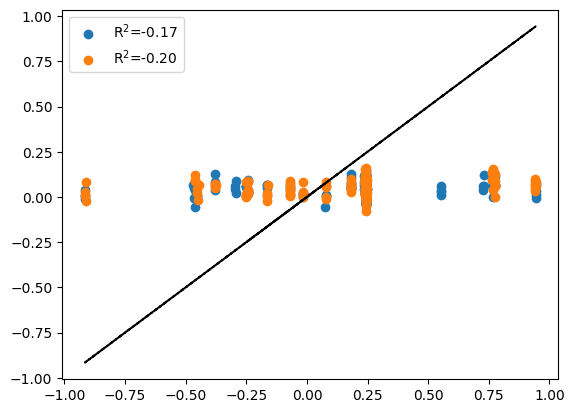

In [12]:
plt.scatter(y_train.flatten(),y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_train.flatten(),y_train_pred.flatten()):.2f}")
plt.plot(y_train.flatten(),y_train.flatten(),'k--')
plt.scatter(y_test.flatten(),y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_test.flatten(),y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

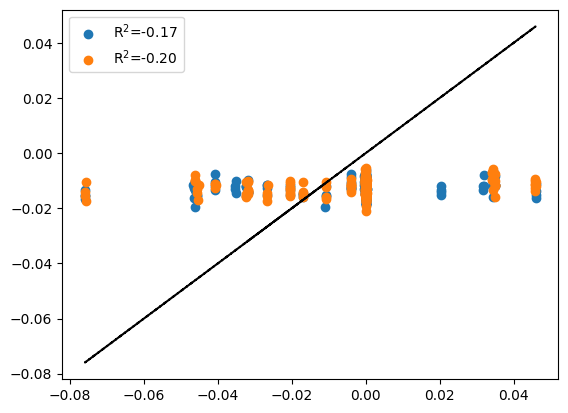

In [13]:
plt.scatter(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten()):.2f}")

plt.plot(unscaled_y_train.flatten(),unscaled_y_train.flatten(),'k--')
plt.scatter(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

In [14]:
# Goal, error handling: RuntimeJobFailureError: 'Unable to retrieve job result. Job estimator_cv61fk0tqh9s73cvpdeg_f0fa_4 cancelled due to compilation timeout 8100000000000.'
